In [9]:
import numpy as np

RNN

In [10]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params # 重みパラメータ
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b # 以前のコンテキスト情報も含めて計算
        h_next = np.tanh(t) # 正規化（次の計算に情報を渡す）

        self.cache(x, h_prev, h_next) # 入力と出力

        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2) # tanhの逆伝播
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

TimeRNN

In [11]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        # あくまでTimeRNNは一つの層としてループしているだけだから使用する重みは全ループで共通
        self.params = [Wx, Wh, b]
        # そのため最終的な重みの勾配はそれぞれのループで得られた勾配を合計したもの
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None # ブロック間の引き継ぎのためメンバ変数に
        self.stateful = stateful

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

    # 入力xs(分散表現)に対しRNNレイヤを時系列の長さだけ生成してWh+Wx+bを計算（重みは同一）
    def forward(self, xs):
        Wx, Wh, b = self.params # RNN内で使用
        N, T, D = xs.shape # バッチ数、時刻t数（どのx）×次元数（各xの分散表現ベクトル）
        D, H = Wx.shape # 隠れ状態h(N,H)と計算できるように形状を変換 H: 過去の情報における保持量を決める

        self.layers = []
        hs = np.empty((N, T, H), dtype='f') # 単にhを追加するだけだからメモリ確保だけでいい

        # 隠れ状態にしない設定または初回RNN呼び出し時はself.hがNoneだからゼロ行列に初期化
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype = 'f') # 計算に使うから０で初期化

        for t in range(T): # 文字数だけRNNがループする
            layer = RNN(*self.params) # RNN(Wx, Wh, b)と同じ：*を使うと引数の追加・削除が楽
            self.h = layer.forward(xs[:, t, :], self.h) # ht=h_prev*Wh + xt*Wx + b を計算
            hs[:, t, :] = self.h # その計算で出たhtをhsに保存
            self.layers.append(layer) # ループした数分だけレイヤ追加

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params # WhとbはRNN内で使用
        N, T, H = dhs.shape # h=Wh(N,T,D)+Wx(D,H)+bの形状
        D, H = Wx.shape # 隠れ状態h(N,H)と計算できるように形状を変換 H: 過去の情報における保持量を決める

        dxs = np.empty((N, T, D), dtype='f') # 最終的に求める勾配の初期化
        dh = 0 # 一番最初の計算では
        grads = [0, 0, 0]
        # 時間ステップ（RNNレイヤ）を逆順に
        for t in reversed(range(T)):
            layer = self.layers[t]
            # 前伝播の時はhを複製(repeat)して出力側とt+1に渡し、逆伝播の時はそれぞれの勾配の合計を求める
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad # 全てのRNNでの勾配を考慮しモデル全体の最適化をする

        for i, grad in enumerate(grads): # 合計されたそれぞれの重み勾配
            self.grads[i][...] = grad # メンバ変数に要素だけコピー
        self.dh = dh # ７章で扱う

        return dxs # 前レイヤ（Embeddingレイヤ）に渡す


In [12]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b] # W(H, V), b(V,)
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape # バッチ数、時刻、次元（H）
        W, b = self.params

        rx = x.reshape(N * T, -1) # T行(T,H)でまとめる
        out = np.dot(rx, W) + b #x(T,H)とW(H,V)
        self.x = x # 逆伝播用
        return out.reshape(N, T, -1) # バッチごとのデータに戻す

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N * T, -1)
        rx = x.reshape(N * T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape) #reshape(N, T, -1)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

In [13]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from common.layers import Embedding

class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype="f")
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W) # 全分散表現をセット
            out[:, t, :] = layer.forward(xs[:, t]) # 時刻tの分散表現だけを呼ぶ
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        # 全時刻のそれぞれの対応する分散表現に対する勾配を累積する
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

In [14]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from common.functions import softmax

class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        # 正解ラベル(ts)に-1が入る場合、それを除外しsoftmaxと損失計算する
        # e.g1. 入力より正解のシーケンスの長さが短い時その分-1を追加して長さを統一する
        # e.g2. 特定の単語（頻出しない単語）を無視したい
        # e.g3. 入力データの一部が欠損している場合や、データ収集時に一部のラベルが取得できなかった場合
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 教師ラベルがone-hotベクトルの場合
            ts = ts.argmax(axis=2)

        # tsのうち-1ではないものをTrue、-1のものをFalse(後の計算でFalseの要素は無視)
        mask = ts != self.ignore_label

        # バッチ分と時系列分をまとめる（reshape）
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        # まず通常通りsoftmaxと、各データの損失までを計算
        ys = softmax(xs)
        # ysにおいて何番目のデータのts番目(インデックス)の確率をlogにいれて損失計算
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_labelに該当するデータは損失を0にする
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelに該当するデータは勾配を0にする

        dx = dx.reshape((N, T, V))

        return dx

In [15]:
# coding: utf-8
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f') # 標準偏差0.01
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f') # Xavierの初期化
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()


学習コード

corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 412.88
| epoch 2 | perplexity 339.51
| epoch 3 | perplexity 245.96
| epoch 4 | perplexity 224.48
| epoch 5 | perplexity 212.98
| epoch 6 | perplexity 206.85
| epoch 7 | perplexity 201.08
| epoch 8 | perplexity 197.54
| epoch 9 | perplexity 192.35
| epoch 10 | perplexity 193.35
| epoch 11 | perplexity 190.12
| epoch 12 | perplexity 192.23
| epoch 13 | perplexity 189.67
| epoch 14 | perplexity 189.90
| epoch 15 | perplexity 189.27
| epoch 16 | perplexity 184.75
| epoch 17 | perplexity 182.45
| epoch 18 | perplexity 179.64
| epoch 19 | perplexity 180.80
| epoch 20 | perplexity 180.75
| epoch 21 | perplexity 177.78
| epoch 22 | perplexity 173.87
| epoch 23 | perplexity 170.94
| epoch 24 | perplexity 170.54
| epoch 25 | perplexity 166.56
| epoch 26 | perplexity 165.72
| epoch 27 | perplexity 160.13
| epoch 28 | perplexity 158.08
| epoch 29 | perplexity 154.18
| epoch 30 | perplexity 148.18
| epoch 31 | perplexity 147.37
| epoch 

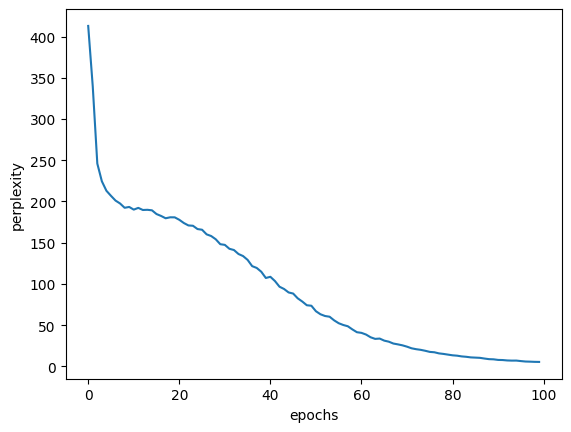

In [16]:
# coding: utf-8
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
import matplotlib.pyplot as plt
from common.optimizer import SGD
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力(最後の単語は入力に含まない)
ts = corpus[1:]  # 出力（教師ラベル）（最初の単語は出力に含まない）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
# offsets を使用してトレーニングデータを一定の間隔で読み込むことで、
# 計算リソースの問題や勾配の爆発・消失などが発生を防ぐ = Truncated BPTT
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1 # リセットされずずっとインクラメント゚する（offset+time_idxが999になるまで）
            # 999になると0を通りながら同じようにインデックス取得 e.g. [996 997 998   0   1]

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    # パープレキシティ：正解ラベルに対して出した確率が高いほど低くなる（分岐数が少ない）
    # 計算方法：eの損失平均乗（確率の逆数）
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')

plt.ylabel('perplexity')
plt.show()
